array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

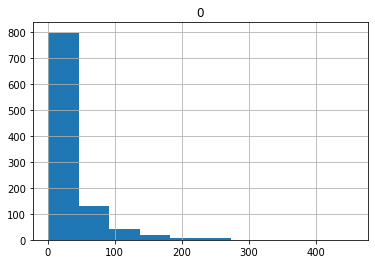

In [154]:
import numpy as np
import pandas as pd


In [1]:
import pandas as pd
import numpy as np
from shapely.wkt import loads
from shapely.geometry import MultiPolygon

# source 2018 yellow cab taxi rides (112M lines; may sample down to 1M for convenience):
# https://data.cityofnewyork.us/Transportation/2018-Yellow-Taxi-Trip-Data/t29m-gskq
# source taxi zones:
# https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc
rides_df = pd.read_csv("./taxis.csv", delimiter=";", parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
zones_df = pd.read_csv("./taxi_zones.csv")


zones_df = zones_df[["LocationID", "the_geom"]].set_index("LocationID")
rides_df = rides_df.join(zones_df, on="PULocationID")
rides_df = rides_df.join(zones_df, on="DOLocationID", rsuffix="DO")

# remove all non-numeric columns
rides_df.drop(
  columns=["tpep_pickup_datetime", "tpep_dropoff_datetime", "store_and_fwd_flag"],
  inplace=True
)

# only keep rows with a dropoff and a pickup point (i.e., no NaN entries)
rides_df = rides_df[rides_df["the_geom"].notnull() & rides_df["the_geomDO"].notnull()]

# produce a randomly weighted average representative point for a given multipolygon 
# NOTE: actually not guaranteed to be inside polygon, as it assumes convexity for simplicity
def generate_representative(poly: MultiPolygon):
  coords = np.array(list(poly.geoms[0].exterior.coords))
  weights = np.abs(np.random.lognormal(100, 10, size=len(coords)))  
  weights += np.abs(np.random.exponential(size=len(coords)))   # generate random weights for each point
  weights = weights / weights.sum()  # normalize weights to sum up to 1
  return (coords.T * weights).sum(axis=1)


# generate a representative geo point for each taxi ride's pick-up and drop-off location, so that 
# we can linearize by geospace
PUrepresentatives = rides_df.apply(
  lambda row: generate_representative(loads(row["the_geom"])), 
  axis=1
)

# np.stack turns array of objects into array of arrays
PUrepresentatives = np.stack(PUrepresentatives)

DOrepresentatives = rides_df.apply(
  lambda row: generate_representative(loads(row["the_geomDO"])), 
  axis=1
)
DOrepresentatives = np.stack(DOrepresentatives)

# store lat and lng as separate attributes
rides_df["PUrepresentativeX"] = PUrepresentatives[:, 0]
rides_df["PUrepresentativeY"] = PUrepresentatives[:, 1]
rides_df["DOrepresentativeX"] = DOrepresentatives[:, 0]
rides_df["DOrepresentativeY"] = DOrepresentatives[:, 1]

# drop unneeded geometry cols
rides_df.drop(columns=["the_geom", "the_geomDO"], inplace=True)

# write the update data back to the file
rides_df.to_csv("./taxisData.csv", sep=";", index=False, header=False)
rides_df  # takes about 15:30 minutes for 1M 

,index,tripID,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PUrepresentativeX,PUrepresentativeY,DOrepresentativeX,DOrepresentativeY
0,0,31852922,2,2,2.00,1,249,161,1,7.5,0.0,0.5,1.66,0.0,0.3,9.96,-74.004931,40.736726,-73.980176,40.759927
1,2,66379394,2,2,1.03,1,239,238,2,6.0,0.0,0.5,0.00,0.0,0.3,6.80,-73.987724,40.782141,-73.966095,40.789734
2,3,10428271,2,1,0.82,1,249,114,1,6.0,0.0,0.5,1.70,0.0,0.3,8.50,-74.000279,40.733218,-73.996536,40.729407
3,4,23940933,1,2,1.80,1,239,166,1,7.5,0.0,0.5,0.42,0.0,0.3,8.72,-73.981725,40.790384,-73.968332,40.809524
4,5,49711511,2,1,1.18,1,236,75,1,6.0,0.0,0.5,2.04,0.0,0.3,8.84,-73.959433,40.782076,-73.939617,40.786720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982877,999995,48567407,2,4,1.90,1,141,142,1,8.5,0.5,0.5,1.96,0.0,0.3,11.76,-73.961716,40.760711,-73.980286,40.771440
982878,999996,67297900,2,6,1.78,1,246,164,2,11.0,0.0,0.5,0.00,0.0,0.3,11.80,-74.008102,40.752363,-73.985113,40.746979
982879,999997,19204703,1,1,0.70,1,162,237,1,6.0,0.0,0.5,2.00,0.0,0.3,8.80,-73.973845,40.757293,-73.962494,40.767157
982880,999998,53762823,4,1,0.84,1,249,125,1,5.5,0.0,0.5,1.26,0.0,0.3,7.56,-74.005256,40.728672,-74.008590,40.723819


In [136]:
rides_df.describe().loc[["min", "max"]]

,index,tripID,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PUrepresentativeX,PUrepresentativeY,DOrepresentativeX,DOrepresentativeY
min,0.0,73.0,1.0,0.0,0.01,1.0,1.0,1.0,1.0,0.01,-0.49,0.0,0.0,0.0,0.0,0.31,-74.190861,40.542776,-74.237539,40.520042
max,999999.0,76955200.0,4.0,9.0,63.30,99.0,263.0,263.0,4.0,398.00,17.50,0.5,300.0,950.7,0.3,1003.50,-73.715146,40.900405,-73.714274,40.900818


In [27]:
import pymorton as pm
import numpy as np

# testing the pymorton sort function
pos = rides_df[["PURepresentativeX", "PURepresentativeY"]]
hashes = pos.apply(lambda row: pm.interleave_latlng(row[0], row[1]), axis=1)
np.argsort(hashes)

0         164430
1         204086
2         338771
3         338763
4         711583
           ...  
999995    265693
999996    786733
999997    197280
999998    624809
999999    723491
Length: 1000343, dtype: int64